In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns

In [3]:
df = pd.read_csv("exchange_rate.csv")

In [5]:
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [6]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [14]:
print(df.head())
print(df.columns)

        date  Ex_rate
0 1990-01-01   0.7855
1 1990-02-01   0.7818
2 1990-03-01   0.7867
3 1990-04-01   0.7860
4 1990-05-01   0.7849
Index(['date', 'Ex_rate'], dtype='object')


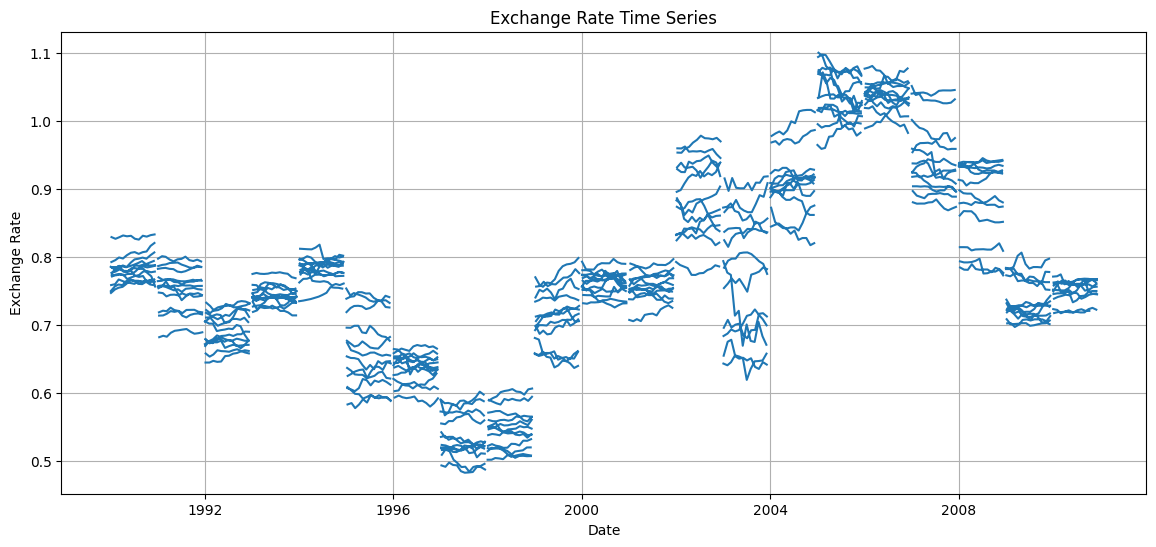

In [15]:

df['date'] = pd.to_datetime(df['date'], errors='coerce')

plt.figure(figsize=(14,6))
plt.plot(df['date'], df['Ex_rate'])
plt.title('Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

In [16]:
# Handle outliers using z-score or IQR method
Q1 = df['Ex_rate'].quantile(0.25)
Q3 = df['Ex_rate'].quantile(0.75)
IQR = Q3 - Q1

# Filter out extreme outliers
df_cleaned = df[(df['Ex_rate'] >= Q1 - 1.5*IQR) & (df['Ex_rate'] <= Q3 + 1.5*IQR)]

print(f"Original rows: {len(df)}, After cleaning: {len(df_cleaned)}")


Original rows: 7588, After cleaning: 7588


In [17]:
#Model Building ARIMA

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


In [19]:
ts = df_cleaned.set_index('date')['Ex_rate']

In [20]:
# Check for stationarity
adf_result = adfuller(ts)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

ADF Statistic: -1.6649941807381528
p-value: 0.4492327353597901


In [21]:
ts_diff = ts.diff().dropna()

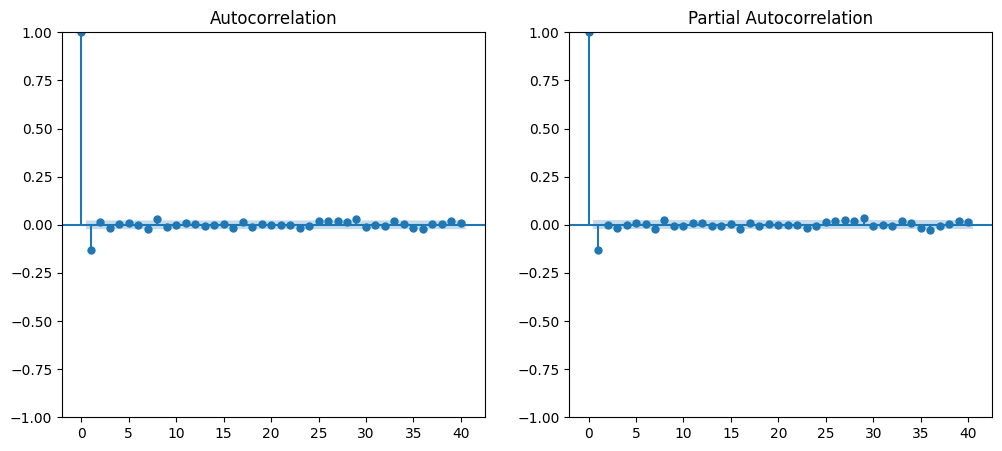

In [22]:
# Plot ACF and PACF
plt.figure(figsize=(12,5))
plt.subplot(121)
plot_acf(ts_diff, ax=plt.gca(), lags=40)
plt.subplot(122)
plot_pacf(ts_diff, ax=plt.gca(), lags=40)
plt.show()

In [24]:
# Model Fitting:

In [25]:
from statsmodels.tsa.arima.model import ARIMA

In [26]:
# Example: ARIMA(p=1, d=1, q=1) – replace with values from your ACF/PACF
model = ARIMA(ts, order=(1,1,1))
model_fit = model.fit()

C:\Users\91822\anaconda3\envs\datasci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\91822\anaconda3\envs\datasci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\91822\anaconda3\envs\datasci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\91822\anaconda3\envs\datasci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_d

In [27]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 19 Nov 2025   AIC                         -56102.322
Time:                        10:54:15   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

In [28]:
residuals = model_fit.resid

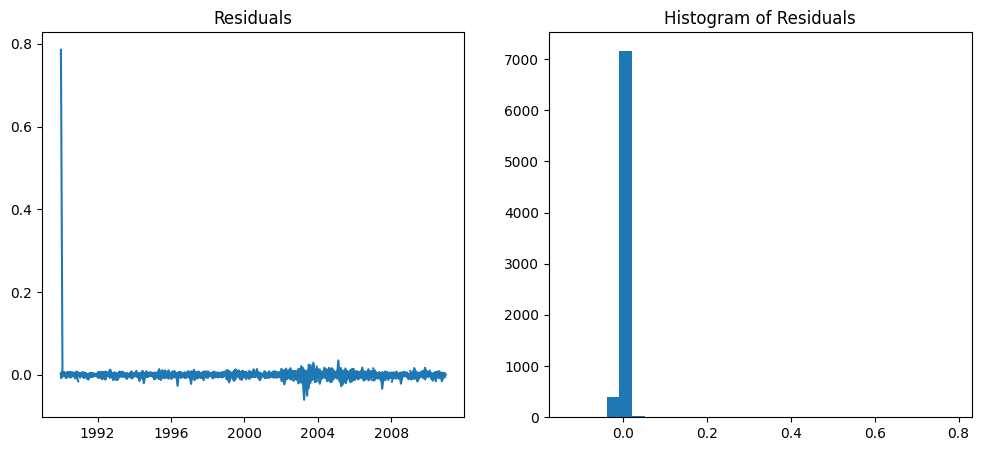

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(122)
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.show()

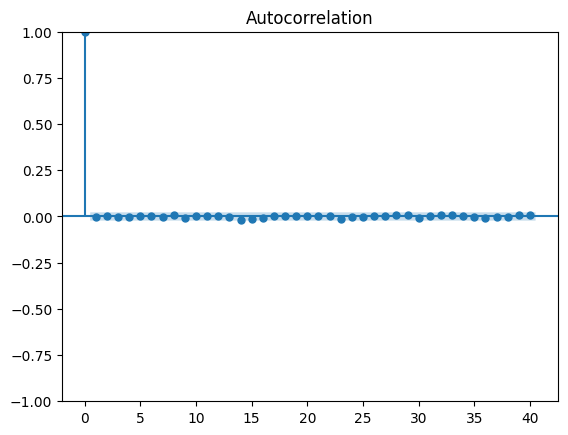

In [30]:
#Check ACF of residuals
plot_acf(residuals, lags=40)
plt.show()


In [31]:
ts.index = pd.to_datetime(ts.index, dayfirst=True)

In [32]:
# Forecast next 30 days
forecast_steps = 30
forecast = model_fit.get_forecast(steps=forecast_steps)

C:\Users\91822\anaconda3\envs\datasci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\91822\anaconda3\envs\datasci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [33]:
# Create datetime index for forecast
forecast_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

In [34]:
# Forecasted series
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
conf_int = forecast.conf_int()

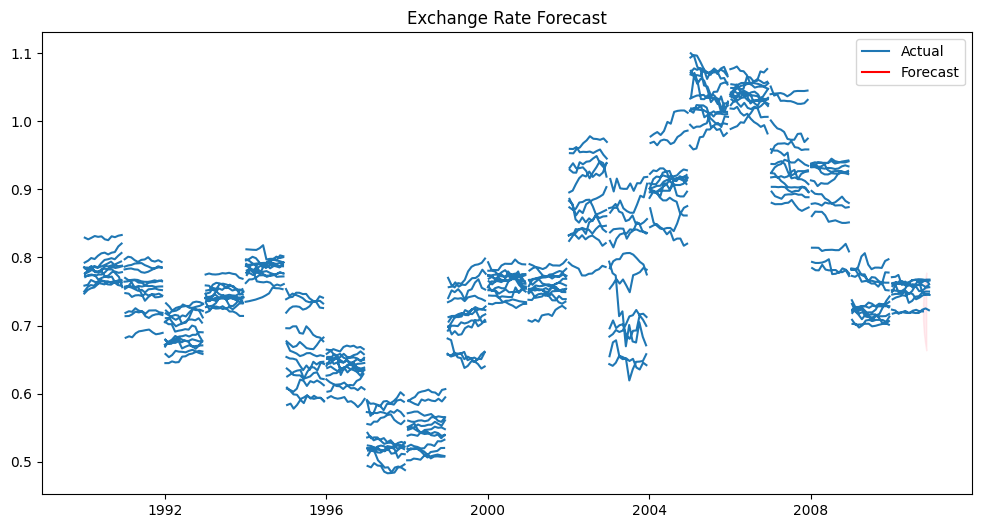

In [35]:
plt.figure(figsize=(12,6))
plt.plot(ts, label='Actual')
plt.plot(forecast_series, color='red', label='Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.title('Exchange Rate Forecast')
plt.legend()
plt.show()

In [36]:
# Model Selection:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [37]:
# Assuming ts is your preprocessed time series
ts.index = pd.to_datetime(ts.index, dayfirst=True)

In [38]:
hw_model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)

C:\Users\91822\anaconda3\envs\datasci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\91822\anaconda3\envs\datasci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [39]:
print(hw_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77624.615
Trend:                         Additive   BIC                         -77513.666
Seasonal:                      Additive   AICC                        -77624.525
Seasonal Periods:                    12   Date:                 Wed, 19 Nov 2025
Box-Cox:                          False   Time:                         10:58:44
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8701256                alpha                 True
smoothing_trend          

In [40]:
# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(ts).fit(optimized=True)
print(ses_model.params)

{'smoothing_level': np.float64(0.8698462497628352), 'smoothing_trend': np.float64(nan), 'smoothing_seasonal': np.float64(nan), 'damping_trend': nan, 'initial_level': np.float64(0.7855), 'initial_trend': np.float64(nan), 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


C:\Users\91822\anaconda3\envs\datasci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\91822\anaconda3\envs\datasci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [41]:
# Holt's Linear Trend
holt_model = Holt(ts).fit(optimized=True)
print(holt_model.params)

C:\Users\91822\anaconda3\envs\datasci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\91822\anaconda3\envs\datasci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


{'smoothing_level': np.float64(0.8695445611372759), 'smoothing_trend': np.float64(0.008904015800954066), 'smoothing_seasonal': np.float64(nan), 'damping_trend': nan, 'initial_level': np.float64(0.7855), 'initial_trend': np.float64(-0.0036999999999999256), 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [42]:
# Forecasting next 30 days
forecast_steps = 30
hw_forecast = hw_model.forecast(forecast_steps)

C:\Users\91822\anaconda3\envs\datasci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\91822\anaconda3\envs\datasci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [43]:
# Create datetime index for forecast
forecast_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
hw_forecast = pd.Series(hw_forecast.values, index=forecast_index)

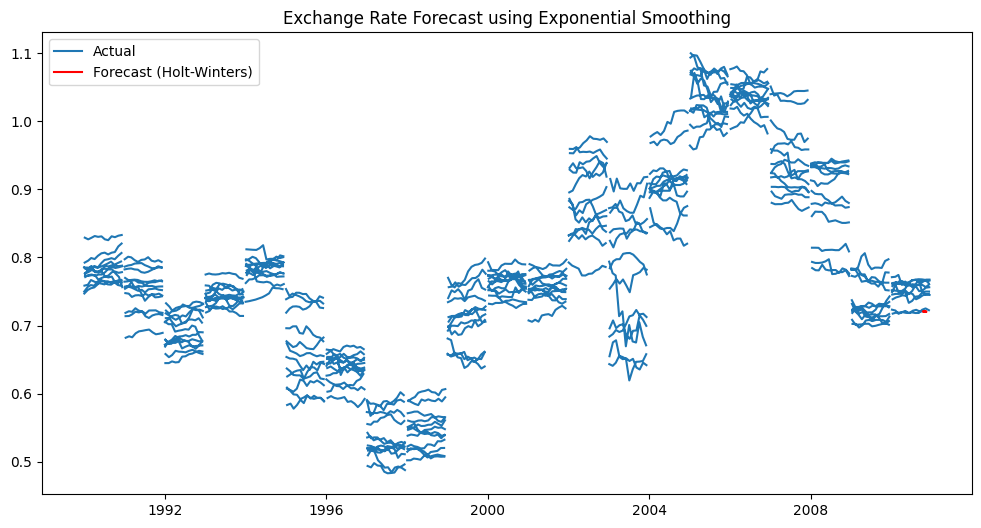

In [44]:
# Plotting actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(ts, label='Actual')
plt.plot(hw_forecast, color='red', label='Forecast (Holt-Winters)')
plt.title('Exchange Rate Forecast using Exponential Smoothing')
plt.legend()

In [45]:
# 1.Compute Error Metrics:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [46]:
actual = ts[-30:]  
arima_forecast = forecast_series[:30] 
hw_forecast = hw_forecast[:30] 

In [47]:
# Holt-Winters Error Metrics
hw_mae = mean_absolute_error(actual, hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(actual, hw_forecast))
hw_mape = np.mean(np.abs((actual - hw_forecast)/actual)) * 100

In [49]:
print("Holt-Winters Errors:")
print(f"MAE: {hw_mae:.4f}, RMSE: {hw_rmse:.4f}, MAPE: {hw_mape:.2f}%")

Holt-Winters Errors:
MAE: 0.0129, RMSE: 0.0172, MAPE: 3.41%
